#Import libraries

In [137]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
from google.colab import drive
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML 

#Read voices

##Unzip voices

In [138]:
# Run it for first run

#drive.mount("/content/drive")
#!unzip "/content/drive/My Drive/female.zip"
#!unzip "/content/drive/My Drive/male.zip"

##Checking voices and ploting them

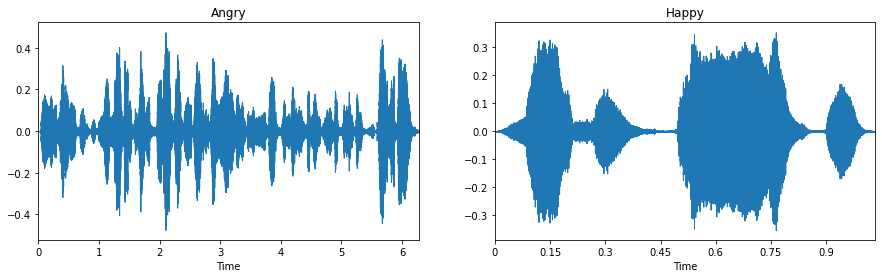

In [139]:
with soundfile.SoundFile('./female/F01A03.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Angry')

with soundfile.SoundFile('./female/F01H03.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 2, 2)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Happy')

#Preprocess voices

In [140]:
import librosa

def feature_chromagram(waveform, sample_rate):
    stft_spectrogram=np.abs(librosa.stft(waveform))
    
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

def get_features(file):
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        
        return feature_matrix

##Import json text files

In [141]:
import json
from google.colab import drive

f = open('shemo.json')
  
data = json.load(f)
json_data = {}
for i in data:
    json_data[i] = data[i]
print(len(json_data))
f.close()

3000


##Matching audio files with json files

In [157]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for filename in glob.glob(os.path.join('female', '*.wav')):
        file_name=os.path.basename(filename)
        if file_name[:-4] in json_data.keys():
            emotion = json_data[file_name[:-4]]['emotion']
            features = get_features(filename)
            X.append(features)
            y.append(emotion)
            count += 1
            print('\r' + f' Processed {count} female audio samples',end=' ')
    
    print(f' Processed {count} female audio samples',end=' ')
    count_m = 0
    for filename in glob.glob(os.path.join('male', '*.wav')):
        file_name=os.path.basename(filename)
        if file_name[:-4] in json_data.keys():
            emotion = json_data[file_name[:-4]]['emotion']
            features = get_features(filename)
            X.append(features)
            y.append(emotion)
            count_m += 1
            print('\r' + f' Processed {count_m} male audio samples',end=' ')
    print('')
    print(f' Processed {count} female audio samples')
    print(f' Processed {count_m+count} total audio samples')
    return np.array(X), np.array(y)

features, emotions = load_data()

 Processed 1646 male audio samples 
 Processed 1192 female audio samples
 Processed 2838 total audio samples


##Plot data by their emotions

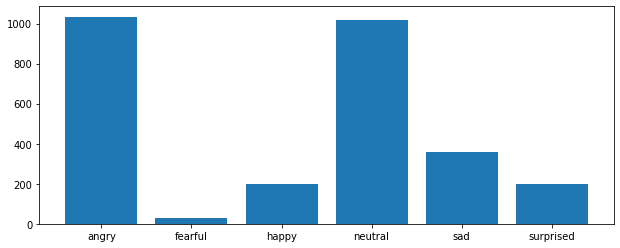

In [158]:
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)

emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(len(emotion_list)), height=count)
plt.xticks(ticks=range(len(emotion_list)), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.show()

##Scaling data

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()

features_scaled = features 
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()

features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

##Train test data split

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

#Classify train data

In [146]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),
    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))

scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
2,SVC RBF kernel,74.65%
4,RandomForestClassifier,73.06%
1,SVC,69.54%
0,KNeighborsClassifier,69.37%
5,AdaBoostClassifier,66.73%
7,QuadraticDiscriminantAnalysis,63.91%
3,DecisionTreeClassifier,62.50%
6,GaussianNB,58.10%


In [147]:
from sklearn.svm import SVC

model = SVC(
    C=10,
    gamma='auto',
    kernel='rbf',
    random_state=69
)

model.fit(X_train, y_train)

print('SVC Model accuracy on training set is '+ str(100*model.score(X_train, y_train))+ '%')
print('SVC Model accuracy on test set is '+ str(100*model.score(X_test, y_test)) + '%')

SVC Model accuracy on training set is 99.95594713656388%
SVC Model accuracy on test set is 43.66197183098591%


In [148]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

model.fit(X_train, y_train)

print('Default KNN Model accuracy on training set is '+ str(100*model.score(X_train, y_train))+'%')
print('Default KNN Model accuracy on test set is '+ str(100*model.score(X_test, y_test))+'%')

model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    leaf_size = '30',
    n_jobs=4
)

model.fit(X_train, y_train)

print('KNN Model accuracy on training set is '+ str(100*model.score(X_train, y_train))+'%')
print('KNN Model accuracy on test set is '+ str(100*model.score(X_test, y_test))+'%')

Default KNN Model accuracy on training set is 77.48898678414096%
Default KNN Model accuracy on test set is 69.36619718309859%
KNN Model accuracy on training set is 99.95594713656388%
KNN Model accuracy on test set is 70.59859154929578%


In [149]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=69)

model.fit(X_train, y_train)

print('Default Random Forest Model accuracy on training set is '+ str(100*model.score(X_train, y_train))+'%')
print('Default Random Forest Model accuracy on test set is '+ str(100*model.score(X_test, y_test))+'%')


model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True',
    random_state=69  
) 

model.fit(X_train, y_train)

print('Random Forest Model accuracy on training set is '+ str(100*model.score(X_train, y_train))+'%')
print('Random Forest Model accuracy on test set is ' + str(100*model.score(X_test, y_test))+'%')

Default Random Forest Model accuracy on training set is 99.95594713656388%
Default Random Forest Model accuracy on test set is 73.06338028169014%
Random Forest Model accuracy on training set is 99.95594713656388%
Random Forest Model accuracy on test set is 73.06338028169014%


In [150]:
print('Random Forest Model OOB score: '+ str(100*model.oob_score_)+'%')

Random Forest Model OOB score: 71.45374449339207%


In [151]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
    random_state = 69
)

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

model.fit(X_train, y_train)

print('Unscaled MLP Model accuracy on training set is ' + str(100*model.score(X_train, y_train))+'%')
print('Unscaled MLP Model accuracy on test set is ' + str(100*model.score(X_test, y_test))+'%')

Unscaled MLP Model accuracy on training set is 94.40528634361233%
Unscaled MLP Model accuracy on test set is 69.36619718309859%


Standard scaled MLP Model accuracy on training set is 99.95594713656388%
Standard scaled MLP Model accuracy on test set is 73.94366197183099%

              precision    recall  f1-score   support

       angry       0.76      0.85      0.80       197
     fearful       0.00      0.00      0.00         6
       happy       0.52      0.33      0.41        33
     neutral       0.79      0.83      0.81       220
         sad       0.65      0.61      0.63        70
   surprised       0.58      0.36      0.44        42

    accuracy                           0.74       568
   macro avg       0.55      0.50      0.52       568
weighted avg       0.72      0.74      0.73       568




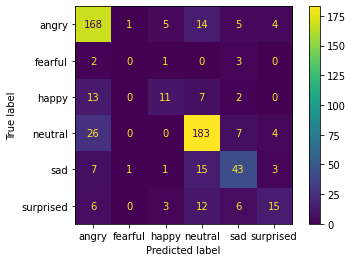

In [152]:
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)
model.fit(X_train_scaled, y_train)

print('Standard scaled MLP Model accuracy on training set is '+ str(100*model.score(X_train_scaled, y_train))+'%')
print('Standard scaled MLP Model accuracy on test set is '+ str(100*model.score(X_test_scaled, y_test))+'%')
print('')

from sklearn.metrics import classification_report, plot_confusion_matrix

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print('')
plot_confusion_matrix(model,X_test_scaled,y_test)

In [153]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(
    n_splits=10, 
    random_state=69, 
    shuffle=True
)

scores = []
for train_indices, test_indices in kfold.split(X_train, y_train):
    model.fit(X_train[train_indices], y_train[train_indices])
    scores.append(model.score(X_train[test_indices], y_train[test_indices]))

print('KFold CV scores for MLP:')
[print(100*score) for score in scores]
print('Mean score of KFold CV for MLP:'+ str(100*np.mean(scores)) +  ' ± ' + str(100*np.std(scores)))

KFold CV scores for MLP:
66.51982378854625
70.04405286343612
70.04405286343612
68.28193832599119
70.92511013215858
68.72246696035242
72.68722466960352
67.84140969162996
66.96035242290749
68.72246696035242
Mean score of KFold CV for MLP:69.0748898678414 ± 1.7818280542869325
